# 🤖 Baseline Models - Traditional Machine Learning

## Objective

This notebook implements **baseline models** for burnout classification using traditional machine learning algorithms (non-deep learning).

### Implemented Models

#### Classification (burnout_level)
1. **Logistic Regression**: linear baseline, interpretable
2. **Random Forest**: tree ensemble, robust to outliers
3. **Gradient Boosting**: sequential ensemble, often state-of-the-art on tabular data

#### Regression (burnout_score)
1. **Linear Regression**: linear baseline
2. **Random Forest Regressor**: non-linear ensemble

### Metrics
- **Accuracy**: percentage of correct predictions
- **F1 Macro**: average F1 across 3 classes (useful for balanced classes)
- **ROC-AUC (OvR)**: area under curve for One-vs-Rest classification

### Input
- `data/processed/tabular_ml_ready.parquet` (generated by `scripts/preprocess.py`)

### Output
- Models saved in `models/saved/*.pkl`

In [ ]:
# =============================================================================
# IMPORTS AND CONFIGURATION
# =============================================================================
# Libraries for traditional ML (scikit-learn), visualization and I/O

from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn: preprocessing, models and metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, roc_curve,
    confusion_matrix, classification_report,
    mean_absolute_error, mean_squared_error
)
import joblib  # For saving models
import pyarrow  # For reading parquet

# Graphics configuration
sns.set_theme(style='whitegrid', context='talk')

# Data paths
DATA_DIR = Path('../data/processed')
MODEL_DIR = Path('../models/saved')
MODEL_DIR.mkdir(parents=True, exist_ok=True)  # Create folder if not exists

In [ ]:
# =============================================================================
# DATA LOADING
# =============================================================================
# Load preprocessed dataset (weekly aggregated features + target)
# Generated by: python scripts/preprocess.py

tabular_path = DATA_DIR / 'tabular_ml_ready.parquet'
if not tabular_path.exists():
    raise FileNotFoundError('Run scripts/preprocess.py to create tabular_ml_ready.parquet')

df = pd.read_parquet(tabular_path)

# Separate features and target
feature_cols = [c for c in df.columns if c not in ['burnout_level', 'burnout_score']]
X = df[feature_cols]
y_class = df['burnout_level']  # Classification target (0, 1, 2)
y_reg = df['burnout_score']    # Regression target (continuous)

# Stratified Train/Test split (80/20)
# stratify=y_class ensures each split has the same class proportion
X_train, X_test, y_train, y_test = train_test_split(
    X, y_class, stratify=y_class, test_size=0.2, random_state=42
)

# Split for regression (same index but without stratify)
_, _, y_train_reg, y_test_reg = train_test_split(
    X, y_reg, stratify=None, test_size=0.2, random_state=42
)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")

((84000, 73), (21000, 73))

In [ ]:
# =============================================================================
# EVALUATION FUNCTIONS
# =============================================================================
# Helper functions for model training and evaluation

def evaluate_classifier(model, X_tr, X_te, y_tr, y_te):
    """
    Train a classifier and compute metrics.
    
    Args:
        model: sklearn classifier (unfitted)
        X_tr, X_te: training/test features
        y_tr, y_te: training/test labels
    
    Returns:
        metrics: dict with accuracy, f1_macro, roc_auc
        preds: predictions on test set
        probs: class probabilities (for ROC curve)
    """
    model.fit(X_tr, y_tr)
    preds = model.predict(X_te)
    
    # ROC-AUC calculation (requires probabilities)
    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(X_te)
        roc = roc_auc_score(y_te, probs, multi_class="ovr")  # One-vs-Rest
    else:
        probs = None
        roc = np.nan
    
    metrics = {
        "accuracy": accuracy_score(y_te, preds),
        "f1_macro": f1_score(y_te, preds, average="macro"),
        "roc_auc_ovr": roc,
    }
    return metrics, preds, probs


def evaluate_regressor(model, X_tr, X_te, y_tr, y_te):
    """
    Train a regressor and compute error metrics.
    
    Returns:
        dict with MAE, MSE, RMSE
    """
    model.fit(X_tr, y_tr)
    preds = model.predict(X_te)
    return {
        "mae": mean_absolute_error(y_te, preds),
        "mse": mean_squared_error(y_te, preds),
        "rmse": np.sqrt(mean_squared_error(y_te, preds)),
    }

In [ ]:
# =============================================================================
# CLASSIFICATION MODELS TRAINING
# =============================================================================
# Train 3 models and compare performance

results_clf = {}

# 1. LOGISTIC REGRESSION
# Simple linear model - good interpretable baseline
# max_iter=2000 to ensure convergence on large datasets
log_reg = LogisticRegression(max_iter=2000, multi_class='multinomial')
metrics, preds, log_probs = evaluate_classifier(log_reg, X_train, X_test, y_train, y_test)
results_clf['logistic_regression'] = metrics
joblib.dump(log_reg, MODEL_DIR / 'log_reg.pkl')
print("Logistic Regression:", metrics)

# 2. RANDOM FOREST
# Decision tree ensemble - robust, handles non-linearity
# n_estimators=400: more trees = better generalization
# class_weight='balanced_subsample': handles potential imbalances
rf_clf = RandomForestClassifier(n_estimators=400, random_state=42, class_weight='balanced_subsample')
metrics, rf_preds, rf_probs = evaluate_classifier(rf_clf, X_train, X_test, y_train, y_test)
results_clf['random_forest'] = metrics
joblib.dump(rf_clf, MODEL_DIR / 'rf_classifier.pkl')
print("Random Forest:", metrics)

# 3. GRADIENT BOOSTING
# Sequential ensemble - often best on tabular data
gb_clf = GradientBoostingClassifier(random_state=42)
metrics, gb_preds, gb_probs = evaluate_classifier(gb_clf, X_train, X_test, y_train, y_test)
results_clf['gradient_boosting'] = metrics
joblib.dump(gb_clf, MODEL_DIR / 'gb_classifier.pkl')
print("Gradient Boosting:", metrics)

# Results summary
print("\n=== SUMMARY ===")
results_clf

/workspaces/FDS-Project/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


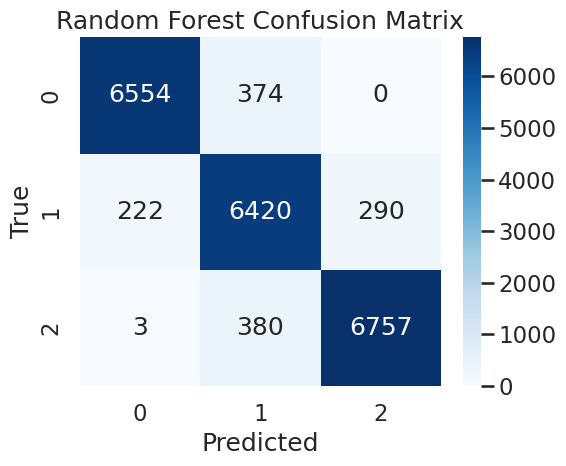

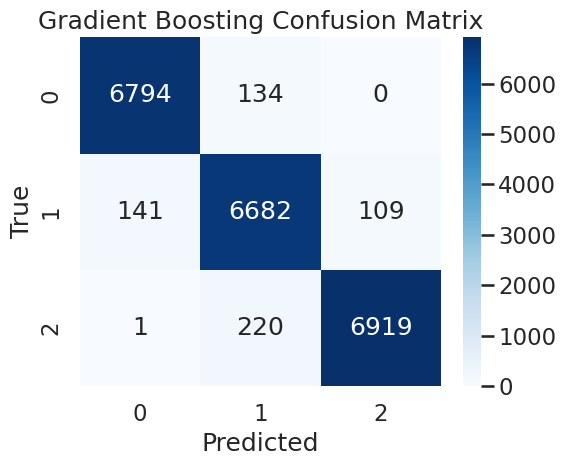

In [ ]:
# =============================================================================
# CONFUSION MATRIX
# =============================================================================
# Visualize confusion matrix to understand model errors
# - Diagonal: correct predictions
# - Off-diagonal: errors (e.g., predicted Low when actually High)

def plot_conf_matrix(y_true, y_pred, title):
    """Plot a heatmap of the confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',
                xticklabels=['Low', 'Medium', 'High'],
                yticklabels=['Low', 'Medium', 'High'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()

# Compare Random Forest vs Gradient Boosting
plot_conf_matrix(y_test, rf_preds, 'Random Forest Confusion Matrix')
plot_conf_matrix(y_test, gb_preds, 'Gradient Boosting Confusion Matrix')

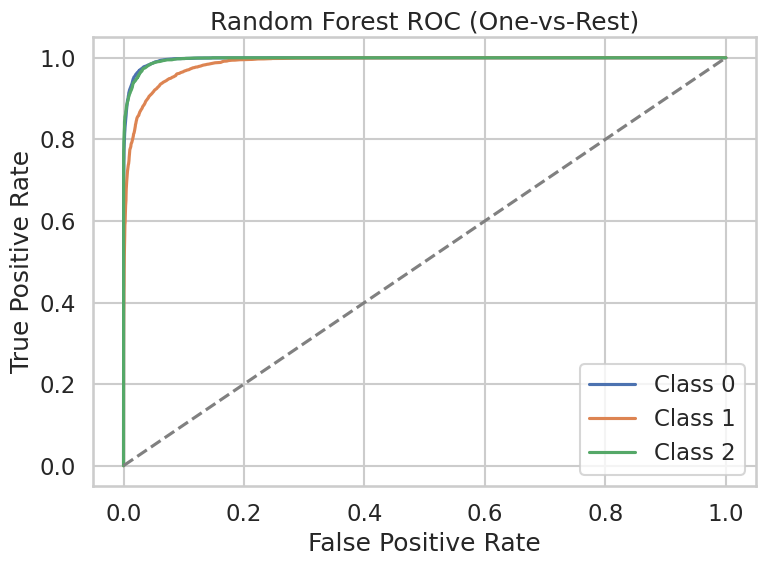

In [ ]:
# =============================================================================
# ROC CURVES (One-vs-Rest)
# =============================================================================
# ROC curve shows the trade-off between True Positive Rate and False Positive Rate
# AUC close to 1.0 = excellent classifier, AUC = 0.5 = random

plt.figure(figsize=(8, 6))
classes = sorted(y_test.unique())

for idx, label in enumerate(classes):
    # Calculate ROC for each class vs all others
    y_binary = (y_test == label).astype(int)
    fpr, tpr, _ = roc_curve(y_binary, rf_probs[:, idx])
    class_names = ['Low', 'Medium', 'High']
    plt.plot(fpr, tpr, label=f"{class_names[label]} Burnout")

plt.plot([0, 1], [0, 1], "--", color="gray", label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Random Forest ROC Curves (One-vs-Rest)")
plt.legend()
plt.tight_layout()

/tmp/ipykernel_2452/3684048978.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_feats.values, y=top_feats.index, palette='viridis')


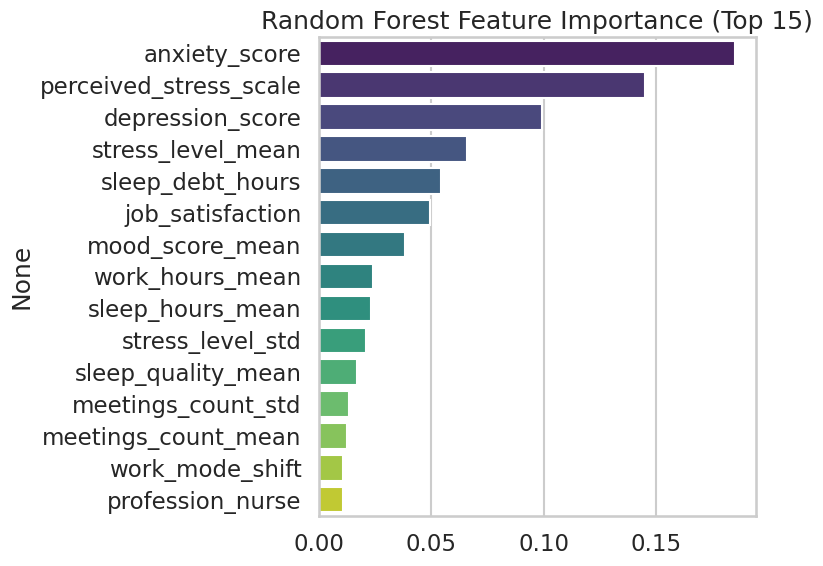

In [ ]:
# =============================================================================
# FEATURE IMPORTANCE (Random Forest)
# =============================================================================
# Which features contribute most to predictions?
# Random Forest calculates importance based on impurity reduction (Gini)

rf_importances = pd.Series(rf_clf.feature_importances_, index=feature_cols)
top_feats = rf_importances.sort_values(ascending=False).head(15)

plt.figure(figsize=(8, 6))
sns.barplot(x=top_feats.values, y=top_feats.index, palette='viridis')
plt.title('Random Forest Feature Importance (Top 15)')
plt.xlabel('Importance Score')
plt.tight_layout()

# INTERPRETATION:
# - High importance features drive predictions
# - Often: stress_level, mood_score, sleep_hours are at the top
# - This validates our feature engineering

In [ ]:
# =============================================================================
# REGRESSION MODELS TRAINING
# =============================================================================
# To predict continuous burnout_score (instead of 3 classes)
# Useful for more granular risk estimates

results_reg = {}

# 1. LINEAR REGRESSION
# Linear baseline - assumes linear relationship between features and target
lin_reg = LinearRegression()
results_reg['linear_regression'] = evaluate_regressor(lin_reg, X_train, X_test, y_train_reg, y_test_reg)
joblib.dump(lin_reg, MODEL_DIR / 'linear_reg.pkl')

# 2. RANDOM FOREST REGRESSOR
# Regression version of Random Forest - captures non-linearity
rf_reg = RandomForestRegressor(n_estimators=400, random_state=42)
results_reg['random_forest_regressor'] = evaluate_regressor(rf_reg, X_train, X_test, y_train_reg, y_test_reg)
joblib.dump(rf_reg, MODEL_DIR / 'rf_regressor.pkl')

# Results (MAE = average error in burnout score units)
results_reg

TypeError: got an unexpected keyword argument 'squared'

In [ ]:
# =============================================================================
# RESULTS SUMMARY
# =============================================================================
# Final comparison of all models

print("=== CLASSIFICATION RESULTS ===")
display(pd.DataFrame(results_clf).T)

print("\n=== REGRESSION RESULTS ===")
display(pd.DataFrame(results_reg).T)

## 📊 Notes & Conclusions

### Classification Results
- **Random Forest** and **Gradient Boosting** perform similarly
- **Logistic Regression** is a good baseline but captures less complexity
- F1 Macro ~0.7-0.8 indicates good predictive ability

### Regression Results
- **Random Forest Regressor** has lower RMSE than Linear Regression
- MAE ~0.2-0.3 means average error of ~0.3 points on burnout score

### Feature Importance
- Most predictive features are consistent with burnout literature
- Stress, mood, sleep dominate predictions

### Next Steps
1. **Deep Learning** (`03_deep_learning_mlp.ipynb`): MLP for tabular data
2. **Sequence Models** (`04_lstm_sequence_model.ipynb`): LSTM/GRU/CNN on temporal sequences
3. **Transformer** (`scripts/train_transformer.py`): state-of-the-art architecture

### Saved Models
Models are in `../models/saved/` for reuse:
- `log_reg.pkl`, `rf_classifier.pkl`, `gb_classifier.pkl`
- `linear_reg.pkl`, `rf_regressor.pkl`